## Лабораторная работа № 9: **Кластеризация**
Выполнил: Русин Ярослав, гр. № 6135

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.simplefilter(action='ignore')
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/Datasets/heart_disease.zip -d data

Archive:  /content/drive/MyDrive/Datasets/heart_disease.zip
  inflating: data/heart.csv          


# Описание исходных данных

Данные: https://www.kaggle.com/ronitf/heart-disease-uci

#### Входные переменные:

- age - возраст
- sex - пол (0 - женщина; 1 - мужчина)
- cp - тип боли в груди (4 значения)
- trestbps - артериальное давление в покое
- chol - холесторал сыворотки в мг / дл
- fbs - уровень сахара в крови натощак> 120 мг / дл (1 - да; 0 - нет)
- restecg - результаты электрокардиографии в покое (значения 0,1,2)
- thalach - достигнутая максимальная частота сердечных сокращений
- exang - стенокардия, вызванная физической нагрузкой
- oldpeak - депрессия ST, вызванная упражнениями по сравнению с отдыхом
- slope - наклон сегмента ST при пиковой нагрузке
- ca - количество крупных сосудов (0-3), окрашенных флурозопией
- thal: 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект

- target - Поле «цель» относится к наличию у пациента сердечного заболевания. Это целое число от 0 (не присутствует) до 4.

In [ ]:
hf = pd.read_csv('data/heart.csv')
hf.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [ ]:
features, target = hf.drop('target', axis=1), hf.target

# EDA

Посмотрим на распределения всех числовых признаков в выборке:

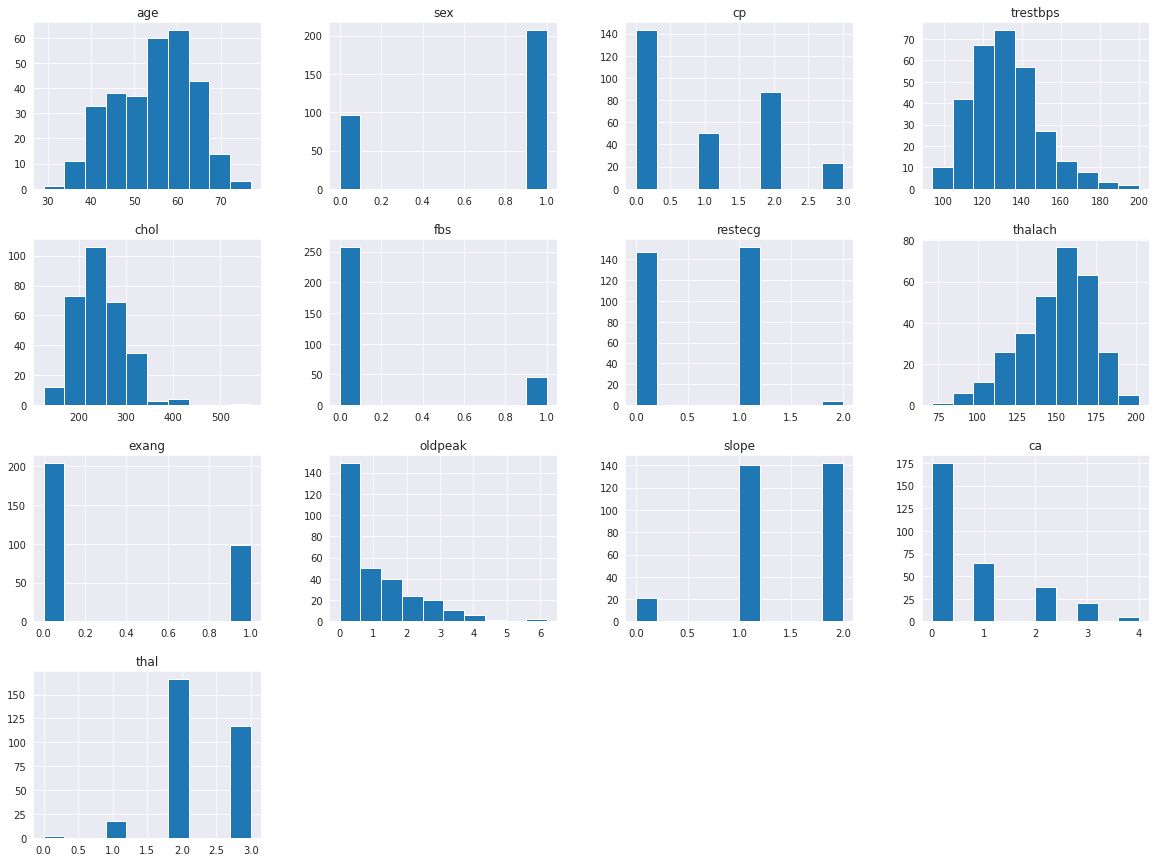

In [ ]:
features.hist(figsize=(20,15))
plt.show()

Исследуем категориальный признак и закодируем:

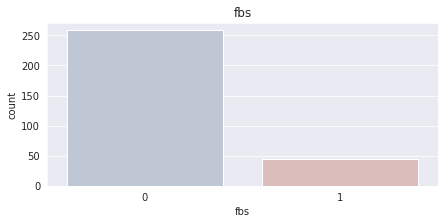

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))
sns.countplot(features['fbs'], ax=ax, palette='vlag')
ax.set(title='fbs')
plt.show()

fbs - уровень сахара в крови натощак> 120 мг / дл (1 - да; 0 - нет). 
По большей части сахар не превышает порог

In [ ]:
features[['0', '1']] =  pd.get_dummies(features['fbs'])
features = features.drop('fbs', axis=1)
features.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,0,1
0,63,1,3,145,233,0,150,0,2.3,0,0,1,0,1
1,37,1,2,130,250,1,187,0,3.5,0,0,2,1,0
2,41,0,1,130,204,0,172,0,1.4,2,0,2,1,0
3,56,1,1,120,236,1,178,0,0.8,2,0,2,1,0
4,57,0,0,120,354,1,163,1,0.6,2,0,2,1,0


*Ищем пропуски*

In [ ]:
nan_percent = 100 * features.isna().sum() / features.shape[0]
nan_percent

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
0           0.0
1           0.0
dtype: float64

Корреляция между признаками:

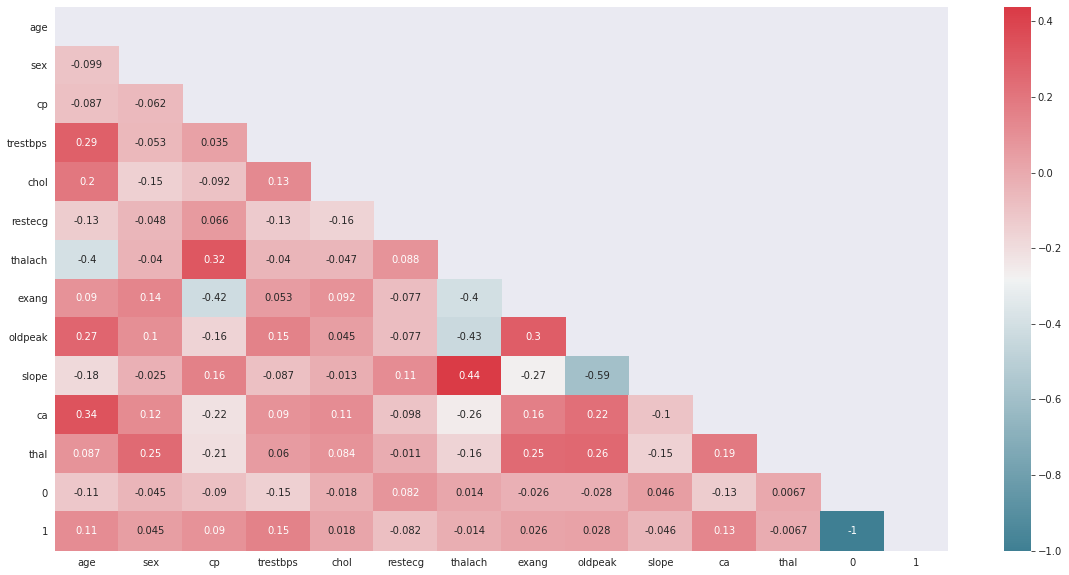

In [ ]:
corr = features.corr(method='spearman')

f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, cmap=cmap, mask=mask, annot = True)
plt.show()

Признаки с **corr >= 0.5**:


- restecg,
- thal,
- slope.



# Иерархическая кластеризация

In [ ]:
import scipy.cluster.hierarchy as shc

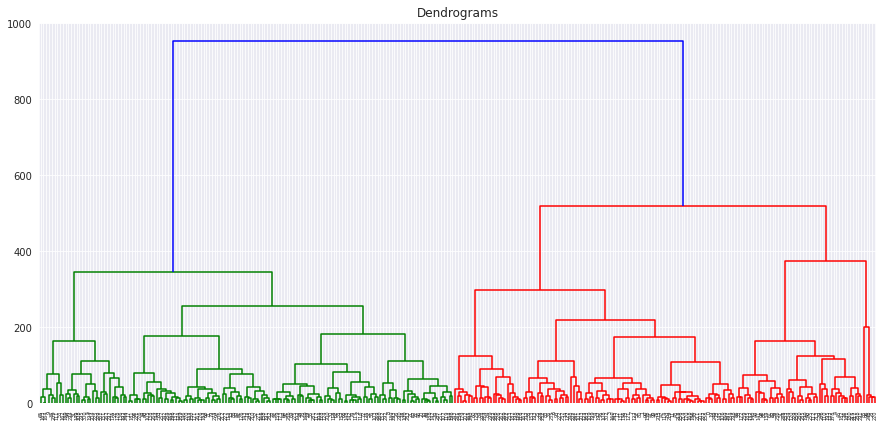

In [ ]:
# с использованием расстояний Уорда
plt.figure(figsize=(15, 7))  
plt.title("Dendrograms") 

clusters = shc.linkage(features, 'ward')
dend =  shc.dendrogram(clusters,             
                       orientation='top',
                       distance_sort='descending',
                       show_leaf_counts=True)

# Kmeans

## Кластеризация без настройки параметров

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import adjusted_rand_score

In [ ]:
clusterer = KMeans(n_clusters=5, random_state=42)
cluster_labels = clusterer.fit_predict(features)

In [ ]:
# Оценка
score_dbscan_ari = adjusted_rand_score(target, cluster_labels)
print('ARI:  %.4f' % score_dbscan_ari)

ARI:  0.0370


## Настройка гиперпараметров

В качестве настраиаемого гиперпараметра будет использован **n_clusters**. Метрика для оптимизации - ARI.

In [ ]:
n_clusters = [*range(2,21,1)]

In [ ]:
ari_scores = []
for _, cluster in tqdm(enumerate(n_clusters)):
  clusterer = KMeans(n_clusters=cluster, random_state=0)
  cluster_labels = clusterer.fit_predict(features)
  ari_scores.append(adjusted_rand_score(target, cluster_labels))

19it [00:02,  8.76it/s]


In [24]:
idx_max = ari_scores.index(max(ari_scores))
print('Лучшее значение ARI: ', ari_scores[idx_max])

Лучшее значение ARI:  0.04389599479737079


## Анализ графика силуэта

In [25]:
scores = []
for _, cluster in tqdm(enumerate(n_clusters)):
    clusters = KMeans(n_clusters=cluster, random_state=42).fit_predict(features)
    scores.append(silhouette_score(features, clusters))

19it [00:02,  7.55it/s]


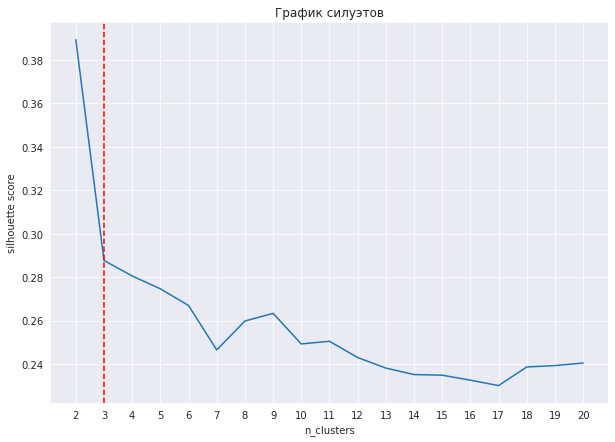

In [26]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(n_clusters, scores)
ax.set(title='График силуэтов', xlabel='n_clusters', ylabel='silhouette score')
ax.set_xticks(n_clusters)
ax.axvline(3, color='red', linestyle='--')
plt.show()

In [27]:
clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(features)
adjusted_rand_score(target, cluster_labels)

0.008492720982724493

## Результат

Kmeans:
- без настройки гиперпараметров (случайные): `0.0370`
- с настройкой гиперпараметра (перебор в цикле): `0.0438`
- с настройкой гиперпараметра (метод локтя,график силуэтов): `0.0084`
#### Самый высокий ARI при настройке гиперпараметра `n_clusters` перебором в цикле и оценкой без настройки гиперпараметров, `n_clusters = 5`
